---

<div align=center>

Practical work

# Photometric analysis of Kuiper Belt Objects

Vincent Foriel\
12/08/2022

</div>

---

## Goal

We have at disposal 2 series of observations, one during the nith of the 8 october 2001 and the other during the night of the 9 october 2001. We want to caracterize an asteroid that figure on these observations.

To do so, we will need these tools:

In [784]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import simple_norm
from photutils.centroids import centroid_quadratic
from photutils import CircularAperture, CircularAnnulus, aperture_photometry
from math import log10

Also, this notebook only manage one serie of observation at a time so please select the serie of observation you want to analyse.

In [785]:
PARENT_PATH = "rsrc/8_Oct/" #@param {type:"string"}
verbose = False #@param {type:"boolean"}
plot_detections = False #@param {type:"boolean"}

if PARENT_PATH == "rsrc/8_Oct/":
    reference_star_pos = np.array((1083, 660))
    first_asteroid_pos = np.array((1150, 1157))
    last_asteroid_pos = np.array((1172, 1104))
elif PARENT_PATH == "rsrc/9_Oct/":
    reference_star_pos = np.array((1683, 1089))
    first_asteroid_pos = np.array((1171, 1166))
    last_asteroid_pos = np.array((1308, 991))
else:
    raise ValueError("Invalid path")

files = []
nbfiles = 0

for file in os.listdir(PARENT_PATH):

    # Filtering undesired files
    if not file.startswith("td10r"):
        continue

    nbfiles += 1
    files.append(file)

if not os.path.isdir("data"):
    os.mkdir("data")

## What is photometric analysis?

> **Answer to question 1**
> 
> Photometric analysis is a technique used to measure the intensity, the psectrum and the position of a light source or illuminated object in order to characterise them. Photometric analysis is commonly used in many fields, such as astronomy (what we will do here), but also in photography, meteorology, or even artificial vision. It can also be used to determine the optical properties of materials, which is useful for engineering and physics research. In short, photometric analysis is an important technique for measuring and understanding the properties of light and its interaction with objects and materials.
>

## Trajectory determination

### Detection algorithm

In this practical work, we will, in a first time, try to find the asteroid location on both series of observation. To do so, we have to solve 2 problems:
- The shifts between two images (due to the telescope that was not perfectly re-alined)
- The time when these images were taken, which is not perfectly periodic and induce kind of spontaneous acceleration/deceleration in the asteroid trajectory

To solve the first problem, we will focus on one of the brightest star present in all the pictures. Using an algorithm that will detect the highest magnitude on a given image (are here, part of image), we will compute the shift according to the change of position of this star.

To do so, we will use this function:

In [786]:
def find_brightest_object(file, pos, box_size, r=8, r_in=15, r_out=25, plot=False):
    """Find the brightest object in a given box."""
    
    # Loading data
    hdulist = fits.open(file)
    header = hdulist[0].header
    scidata = hdulist[0].data

    # Defining the subimage centered on the target
    D = box_size//2
    data = scidata[pos[1]-D:pos[1]+D,pos[0]-D:pos[0]+D]

    # Computing accurately the position of maximum of brightness
    x1, y1 = centroid_quadratic(data)
    positions = [(x1, y1)]

    # Computing the magnitude of the object
    for _ in range(1): # avoid problem with syntaxic coloration caussed by simple_norm()
        norm = simple_norm(data, 'sqrt', percent=99)
    aperture = CircularAperture(positions, r)
    annulus_aperture = CircularAnnulus(positions, r_in, r_out)
    phot_table = aperture_photometry(data, aperture)
    phot_table['aperture_sum'].info.format = '%.8g' # for consistent table output
    Sum_target_raw=(phot_table['aperture_sum'])
    phot_table = aperture_photometry(data, annulus_aperture)
    phot_table['aperture_sum'].info.format = '%.8g' # for consistent table output
    Sky_background=(phot_table['aperture_sum'])
    Sum_target=Sum_target_raw-Sky_background/(r_out*r_out-r_in*r_in)*(r*r)
    mag = -2.5*log10(Sum_target)
    
    # Computing the magnitude of the object with the exposure time
    r_mag = mag + 25 + 2.5 * log10(header['EXPTIME'])

    if plot:
        plt.imshow(data, norm=norm, origin='lower')
        
        aperture.plot(color='white', lw=2)
        annulus_aperture.plot(color='white', lw=2)

        plt.title(file)
        plt.show()

    return np.array([x1+pos[0]-box_size//2, y1+pos[1]-box_size//2]), mag, r_mag

In [787]:
hdu_list = fits.open(PARENT_PATH + files[0])
header = hdu_list[0].header

### Reference points

> **Answer to question 1**
> 
> By looking at the two series of observations, we can see on each one that there is a bright star located (approximatively on the first image) at:
> - 8 October observations: `X=1083`, `Y=660`
> - 9 October observations: `X=1683`, `Y=1089`
>
> We can also observe the asteroid we will consider, located at:
> - 8 October observations:
>   - On first image: `X=1150`, `Y=1157`
>   - On last image: `X=1172`, `Y=1104`
> - 9 October observations:
>   - On first image: `X=1171`, `Y=1166`
>   - On last image: `X=1308`, `Y=991`

### MJD and shifts

Now we can open all the files, get the modified julian date and compute the shifts between the first image and the others.

In [788]:
if verbose:
    print("Image shifts:")

positions = []
shifts = []
mjds = []
first_mjd=None

for file in files:
    path = os.path.join(PARENT_PATH, file)
    
    # Getting the time of observation
    hdulist = fits.open(path)
    mjds.append(hdulist[0].header['MJD-OBS'])

    # Putting first image is at t=0
    if first_mjd is None:
        first_mjd = mjds[-1]
    mjds[-1] -= first_mjd

    # Finding the position of the reference star
    pos, _, _ = find_brightest_object(path, pos = reference_star_pos, box_size=300, plot=plot_detections)
    positions.append(pos)

    # Computing the shift of the image
    shifts.append(np.copy(positions[-1]))
    shifts[-1][0] -= positions[0][0]
    shifts[-1][1] -= positions[0][1]

    # Printing the results
    if verbose:
        print(f"    {file}: x={shifts[-1][0]:.3f}, y={shifts[-1][1]:.3f}")

# Converting to numpy arrays to make it easier to work with
positions = np.array(positions)
shifts = np.array(shifts)
mjds = np.array(mjds)

np.savetxt("data/MJD.txt", mjds)
np.savetxt("data/shifts.txt", shifts)

Once we have theses shifts, we can compute the position of the asteroid on each image by deducing it from the position on the first image and the one on the last image. We remove the shift of the last image to have the position of the object if the telescope was perfectly aligned.

Then, we have an almost straight line and we can ddeduce the position of each image by looking at the long of the line.

In [789]:
print(f"First position:           x={first_asteroid_pos[0]}, y={first_asteroid_pos[1]}")
print(f"Last position:            x={last_asteroid_pos[0]}, y={last_asteroid_pos[1]}")

# Detecting first asteroid position
path = os.path.join(PARENT_PATH, files[0])
first_asteroid_pos, _, _ =  find_brightest_object(path, pos=first_asteroid_pos, box_size=20, r=2.5, r_in=5, r_out=10, plot=plot_detections)

# Detecting last asteroid position
path = os.path.join(PARENT_PATH, files[-1])
last_asteroid_pos, _, _ =  find_brightest_object(path, pos=last_asteroid_pos, box_size=20, r=2.5, r_in=5, r_out=10, plot=plot_detections)

# Applying shift of the last image to correct the last asteroid position
last_asteroid_pos[0] -= shifts[-1][0]
last_asteroid_pos[1] -= shifts[-1][1]

print(f"Corrected first position: x={first_asteroid_pos[0]:.2f}, y={first_asteroid_pos[1]:.2f}")
print(f"Corrected last position:  x={last_asteroid_pos[0]:.2f}, y={last_asteroid_pos[1]:.2f}")

First position:           x=1150, y=1157
Last position:            x=1172, y=1104
Corrected first position: x=1149.48, y=1155.76
Corrected last position:  x=1263.45, y=1107.23


In [790]:
# Computing linspace trajectory
linspace_X = np.linspace(first_asteroid_pos[0], last_asteroid_pos[0], nbfiles, endpoint=True) # mjds[-1]+1
linspace_Y = np.linspace(first_asteroid_pos[1], last_asteroid_pos[1], nbfiles, endpoint=True)

# Computing time correction factors
i = np.arange(nbfiles)
a = mjds / mjds[-1]
a[0] = 1
b = i / i[-1]
b[0] = 1
correction_factors = a / b

# Applying time correction on the linspace
time_correction_X = linspace_X[0] + ((linspace_X - linspace_X[0]) * correction_factors)
time_correction_Y = linspace_Y[0] + ((linspace_Y - linspace_Y[0]) * correction_factors)

# Applying space correction on the linspace
space_correction_X = linspace_X + shifts[:,0]
space_correction_Y = linspace_Y + shifts[:,1]

# Computing asteroid position prediction
predicted_object_pos = np.empty((nbfiles, 2))
predicted_object_pos[:,0] = time_correction_X
predicted_object_pos[:,1] = time_correction_Y
predicted_object_pos[:,0] += shifts[:,0]
predicted_object_pos[:,1] += shifts[:,1]

In [791]:
if verbose:
    print("Asteroïd location:")

real_object_pos = np.empty_like(predicted_object_pos)
object_mag = np.empty(nbfiles)
object_r_mag = np.empty(nbfiles)

error = np.empty_like(predicted_object_pos)

for i, file in enumerate(files):

    path = os.path.join(PARENT_PATH, file)

    # Getting corrected position
    pos, mag, r_mag = find_brightest_object(path, pos=predicted_object_pos[i].astype(int), box_size=20, r=2.5, r_in=5, r_out=10, plot=plot_detections)
    real_object_pos[i] = pos
    object_mag[i] = mag
    object_r_mag[i] = r_mag

    # Computing error
    error[i] = real_object_pos[i] - predicted_object_pos[i]

    if verbose:
        print(f"    {file}: x={real_object_pos[i][0]:.1f}, y={real_object_pos[i][1]:.1f}      Error: x={error[i][0]:.1f}, y={error[i][1]:.1f}")

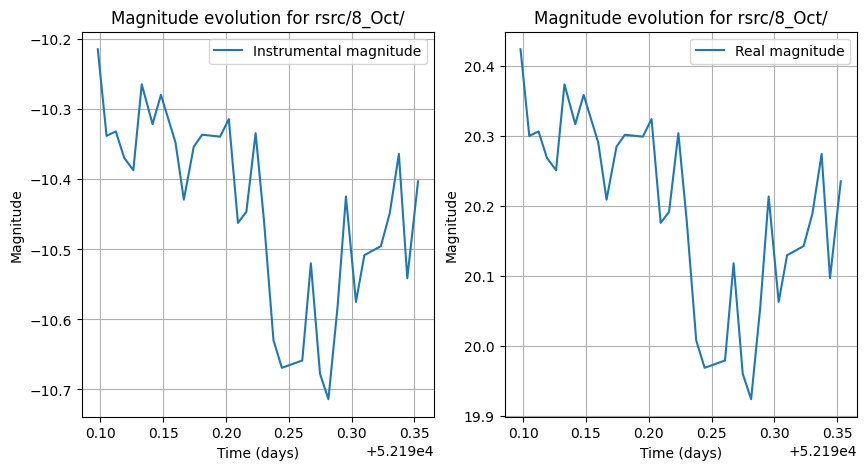

In [792]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(mjds + first_mjd, object_mag, label="Instrumental magnitude")
plt.xlabel("Time (days)")
plt.ylabel("Magnitude")
plt.title(f"Magnitude evolution for {PARENT_PATH}")
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(mjds + first_mjd, object_r_mag, label="Real magnitude")
plt.xlabel("Time (days)")
plt.ylabel("Magnitude")
plt.title(f"Magnitude evolution for {PARENT_PATH}")
plt.legend()
plt.grid()
plt.show()

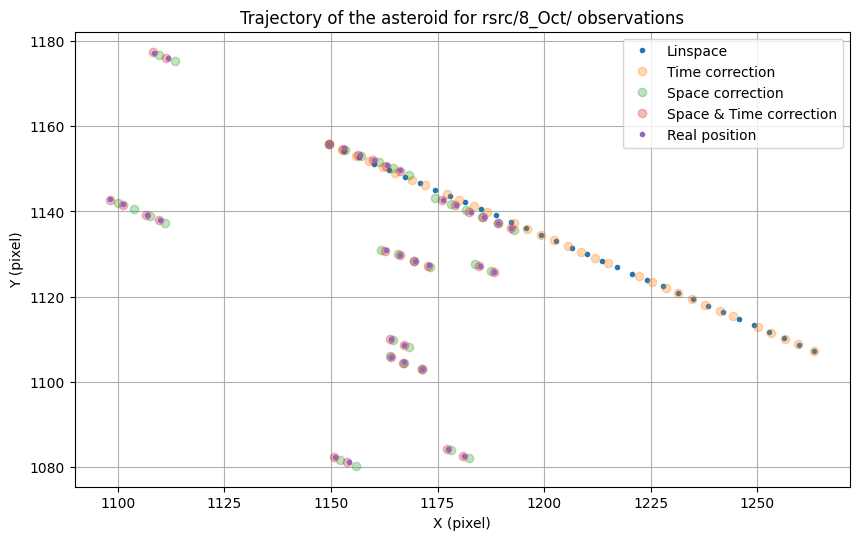

In [793]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(linspace_X, linspace_Y, ".", label="Linspace")
ax.plot(time_correction_X, time_correction_Y, "o", label="Time correction", alpha=0.3)
ax.plot(space_correction_X, space_correction_Y, "o", label="Space correction", alpha=0.3)
ax.plot(predicted_object_pos[:,0], predicted_object_pos[:,1], "o", label="Space & Time correction", alpha=0.3)
ax.plot(real_object_pos[:,0], real_object_pos[:,1], ".", label="Real position")
ax.legend()
ax.grid()
ax.set_aspect('equal')
ax.set_xlabel("X (pixel)")
ax.set_ylabel("Y (pixel)")
ax.set_title(f"Trajectory of the asteroid for {PARENT_PATH} observations")
plt.show()

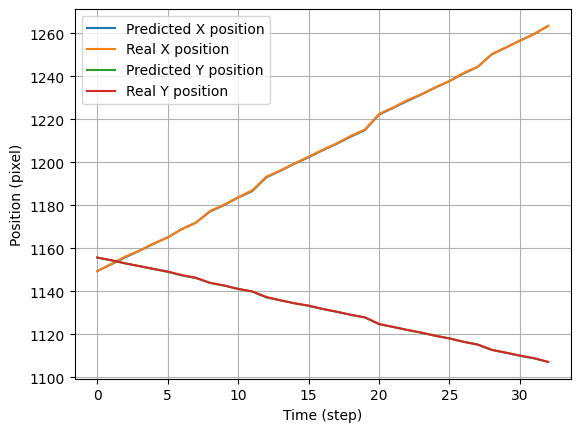

In [794]:
plt.plot(np.arange(nbfiles), predicted_object_pos[:,0]-shifts[:,0], label="Predicted X position")
plt.plot(np.arange(nbfiles), real_object_pos[:,0]-shifts[:,0], label="Real X position")
plt.plot(np.arange(nbfiles), predicted_object_pos[:,1]-shifts[:,1], label="Predicted Y position")
plt.plot(np.arange(nbfiles), real_object_pos[:,1]-shifts[:,1], label="Real Y position")
plt.legend()
plt.xlabel("Time (step)")
plt.ylabel("Position (pixel)")
plt.grid()
plt.show()

Average error: x=0.2, y=0.0
Standard deviation: x=0.1, y=0.1
Incertitude: x=0.2, y=0.2


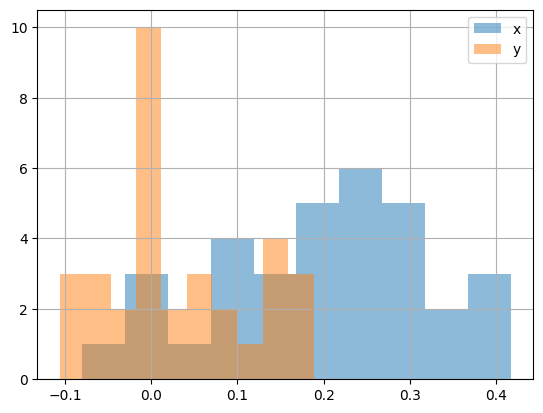

In [795]:
print(f"Average error: x={np.mean(error[:,0]):.1f}, y={np.mean(error[:,1]):.1f}")
print(f"Standard deviation: x={np.std(error[:,0]):.1f}, y={np.std(error[:,1]):.1f}")
print(f"Incertitude: x={2*np.std(error[:,0]):.1f}, y={2*np.std(error[:,1]):.1f}")

plt.hist(error[:,0], bins=10, alpha=0.5, label="x")
plt.hist(error[:,1], bins=10, alpha=0.5, label="y")
plt.legend()
plt.grid()
plt.show()
